In [1]:
import numpy as np
from numpy.linalg import norm
import scipy.spatial as spt
import matplotlib.pyplot as plt
from matplotlib.path import Path
import concave_hull.lineintersect as li
from concave_hull import *

import netCDF4

# Test with only line endpoints

In [2]:
ds = netCDF4.Dataset('http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/magnetic_line/GSQP1029MAG.nc')

In [3]:
latitude_first = ds.variables['latitude_first'][:]
longitude_first = ds.variables['longitude_first'][:]
latitude_last = ds.variables['latitude_first'][:]
longitude_last = ds.variables['longitude_first'][:]

In [4]:
latitudes = np.concatenate((latitude_first, latitude_last), axis=0)
longitudes = np.concatenate((longitude_first, longitude_last), axis=0)

In [5]:
points = np.transpose(np.array([latitudes, longitudes]))

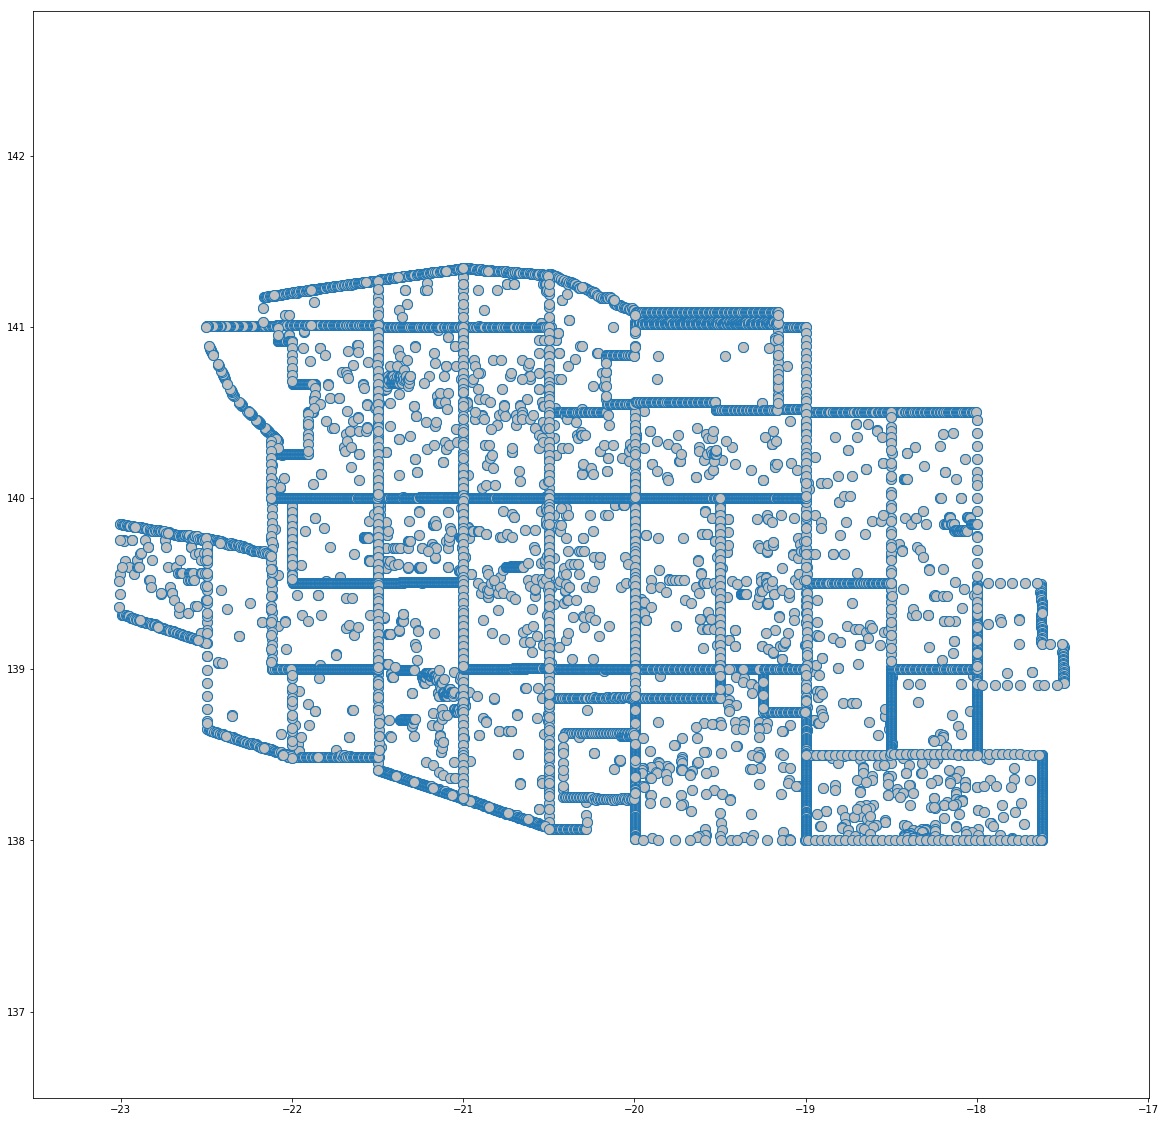

In [6]:
plt.figure(figsize=(20, 20))
plotPoints(points)

In [7]:
%%time
hull_k3 = concaveHull(points, 3)

CPU times: user 2min 9s, sys: 351 ms, total: 2min 9s
Wall time: 2min 20s


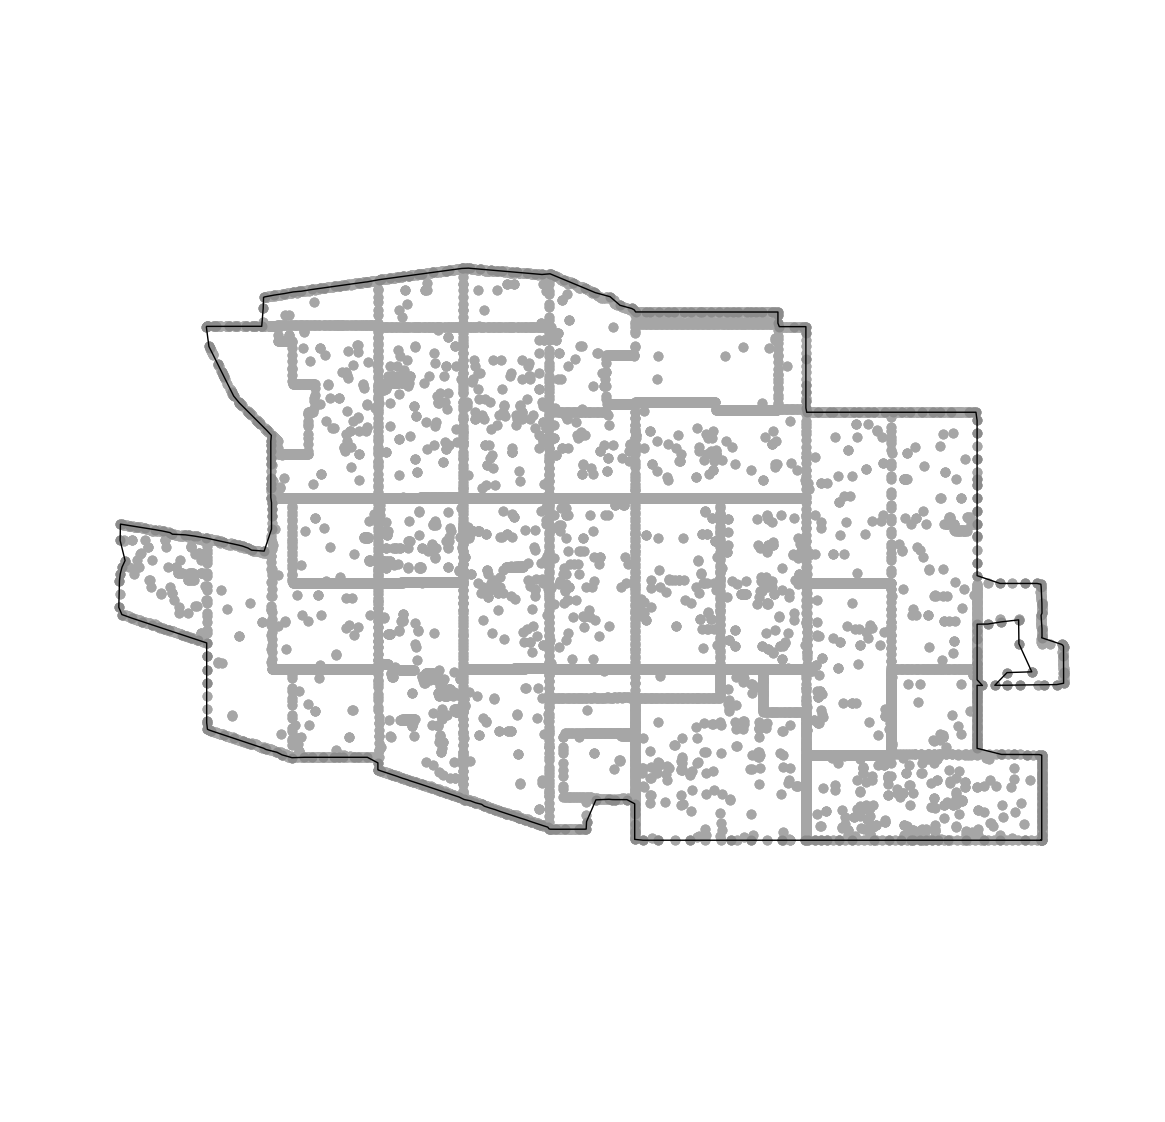

In [8]:
plt.figure(figsize=(20, 20))
plotPath(points, hull_k3)

# Test with a crescent

In [9]:
points = np.array([x for x in [np.random.rand(2) for i in range(1000)]
                   if norm(x - np.array([0.5, 0.5])) < 0.5 and norm(x - np.array([1.0, 1.0])) > 0.75])

In [10]:
hull_k3 = concaveHull(points, 3)

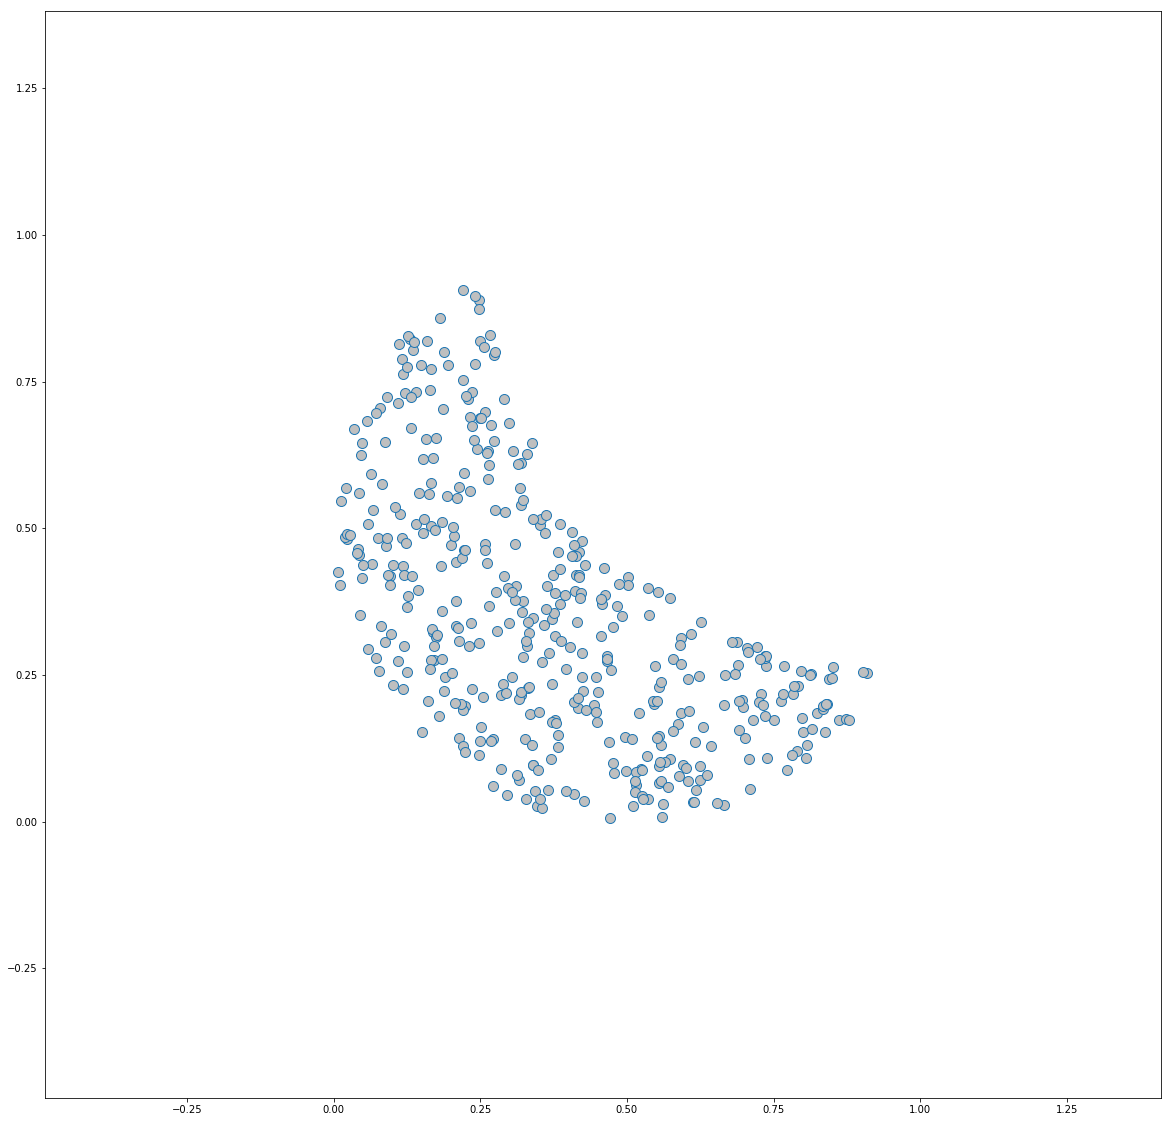

In [11]:
plt.figure(figsize=(20, 20))
plotPoints(points)

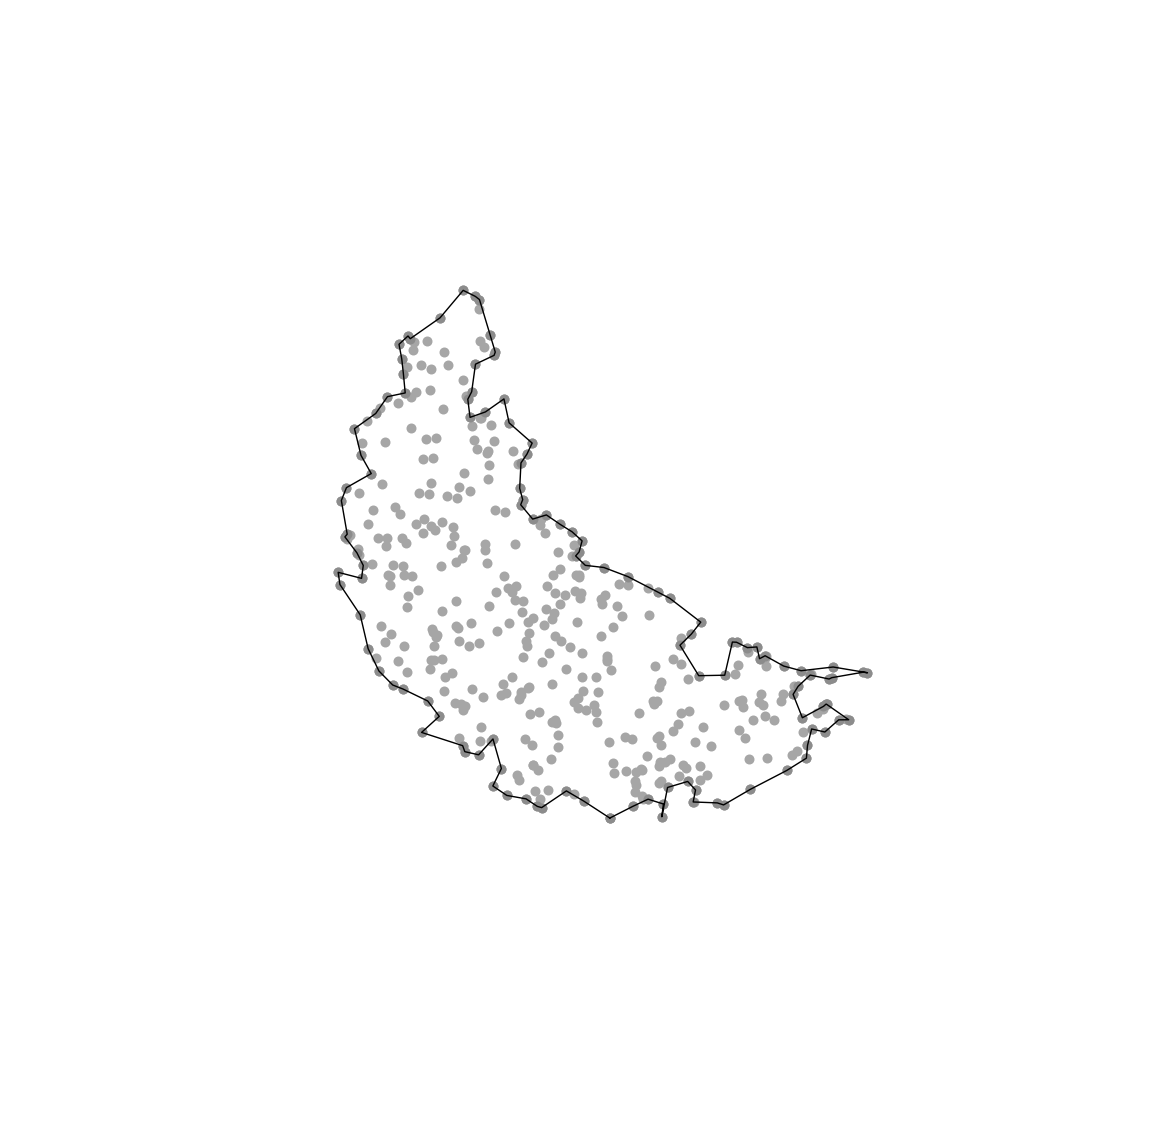

In [12]:
plt.figure(figsize=(20, 20))
plotPath(points, hull_k3)